In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt

df_inf= pd.read_csv('../data/1-12.공공주택임대_정보(화성시).csv')
df_money= pd.read_csv('../data/1-13.공공주택임대_임대료(화성시).csv')
df1_p= pd.read_csv('../data/1-1.화성시_거주인구.csv')
df_map = gpd.read_file('../data/1-14.화성시_격자.geojson')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False  

## 1. 공공주택임대 정보

1. blck_cd    단지 코드
2. blck_nm    단지 명
3. type    공급/지원유형
4. noh    세대수
5. parking_slot    주차면수
6. lon    경도
7. lat    위도

### 지원유형 
- 국민임대 : 저소득층을 위해 국가, 지방자치단체의 재정 지원 지원받아 건설된 임대주택, 무주택 저소득층을 대상, 임대기간은 30년 이상, 60-80퍼센트 수준으로 저렴하게 제공 
- 행복주택 : 청년, 신혼부부, 고령자 등 젊은 층과 취약계층 대상. 대중교통 편리한 곳에 위치, 임대기간 30년
- 영구임대: 최저소득 계층을 위해, 임대료는 시중 시세의 30퍼센트 수준, 50년 이상 or 영구 
-> 현재는 공공통합임대주택으로 통합되었음 
- 공공임대: 5,10년 공공임대 -> 임대 후 분양 전환 가능, 50년 -> 영구임대 목적 , 60-80프로


In [4]:
df_inf.columns=['단지코드','단지명','지원유형','세대수','주차면수','경도','위도']

In [6]:
df_inf.head()

,단지코드,단지명,지원유형,세대수,주차면수,경도,위도
0,C00414,화성태안12,국민임대,1178,1767.0,127.041121,37.217786
1,C00415,화성태안6,국민임대,990,1485.0,127.049830,37.212454
2,C00416,화성태안8,국민임대,836,1254.0,127.047309,37.215054
3,C00447,화성매송(1단지)(국임),국민임대,649,973.5,126.880070,37.266522
4,C01566,화성동탄7-1(1-1)(7단지 능동),국민임대,682,1023.0,127.060256,37.216649


In [7]:
df_inf.지원유형.value_counts()

국민임대    35
행복주택    22
공공임대    13
영구임대     9
Name: 지원유형, dtype: int64

In [9]:
import folium
from folium.plugins import MarkerCluster

# 중심점 설정 (위도와 경도의 평균값 사용)
center_lat = df_inf['위도'].mean()
center_lon = df_inf['경도'].mean()

# 지도 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# MarkerCluster 객체 생성
marker_cluster = MarkerCluster().add_to(m)

# 데이터 포인트를 MarkerCluster에 추가
for _, row in df_inf.iterrows():
    folium.Marker(
        location=[row['위도'], row['경도']],
        popup=f"단지명: {row['단지명']}, 지원유형: {row['지원유형']}"
    ).add_to(marker_cluster)

# 지도 출력
m


### 위경도별로 클러스터링하여 모여있는 곳 확인하기

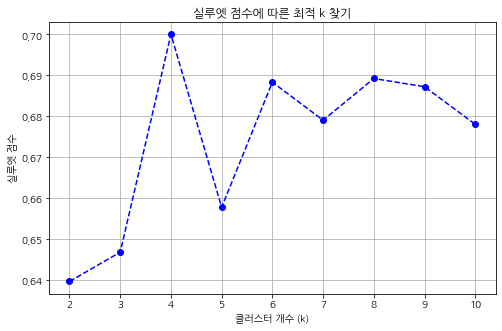

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 위도와 경도 데이터 추출
coords = df_inf[['위도', '경도']]

# 클러스터 개수 범위 설정
k_values = range(2, 11)
silhouette_scores = []

# 각 k에 대해 KMeans 클러스터링 수행 및 실루엣 점수 계산
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(coords)
    score = silhouette_score(coords, cluster_labels)
    silhouette_scores.append(score)

    # 실루엣 점수 vs 클러스터 개수 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title("실루엣 점수에 따른 최적 k 찾기")
plt.xlabel("클러스터 개수 (k)")
plt.ylabel("실루엣 점수")
plt.xticks(k_values)
plt.grid()
plt.show()



In [11]:
from sklearn.cluster import KMeans

coords = df_inf[['위도', '경도']]
kmeans = KMeans(n_clusters=4, random_state=42)
df_inf['cluster'] = kmeans.fit_predict(coords)
df_inf['cluster'].value_counts()

0    37
1    17
3    14
2    11
Name: cluster, dtype: int64

In [14]:
# df_inf.query('cluster == 0')
# df_inf.query('cluster == 1')
# df_inf.query('cluster == 2')
# df_inf.query('cluster == 3')

### 결론 
1. 클러스터 0 지역은 동탄 신도시쪽이다. 
- 국민임대12/ 행복주택11/공공임대10/영구임대4

2. 클러스터 1 지역은 화성 남양뉴타운, 비봉면 쪽에 위치해있음  
- 남양뉴타운: 국민임대4개, 공공임대 1개, 영구임대 1개, 행복주택 3개 
- 화성 비봉: 국민임대 2개, 영구임대 3개, 행복주택 2개 
- 화성 매송: 국민임대 1개 

3. 클러스터 2 지역은 향남 10, 발안 1개
- 국민임대7/행복주택3/공공임대1


4. 클러스터 3 지역은 태안 2지역, 봉담 12개
- 태안: 국민임대 2개
- 봉담: 행복주택 2개, 영구임대 1개, 국민임대 6개, 공공임대 1개


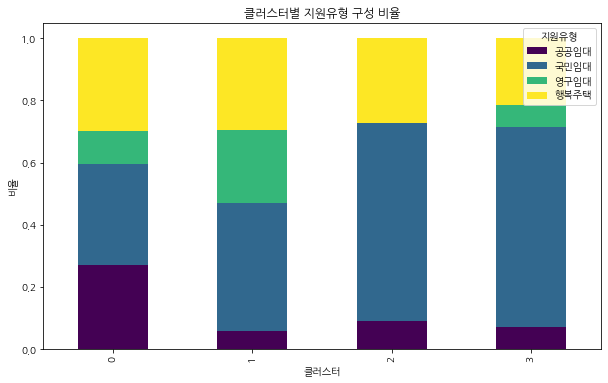

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 지원유형 비율 계산
cluster_support = df_inf.groupby(['cluster', '지원유형']).size().unstack(fill_value=0)

# 비율 계산
cluster_support_percentage = cluster_support.div(cluster_support.sum(axis=1), axis=0)

cluster_support_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('클러스터별 지원유형 구성 비율')
plt.xlabel('클러스터')
plt.ylabel('비율')
plt.legend(title='지원유형')
plt.show()

## 2. 지원유형에 따른 세대수와 주차면수 확인 

In [21]:
grouped = df_inf.groupby('지원유형')[['세대수', '주차면수']].mean().reset_index()

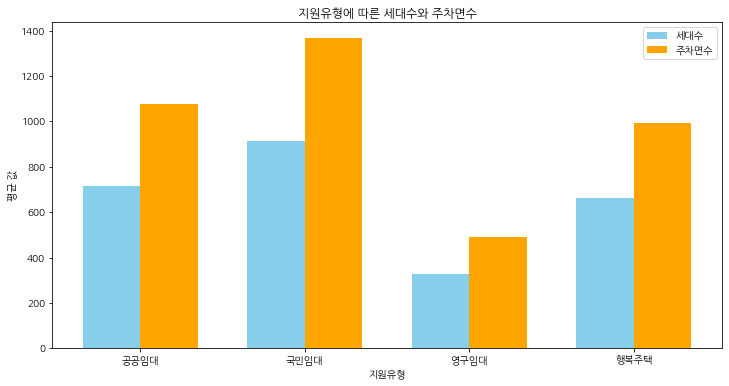

In [22]:
import numpy as np

# 막대 그래프 간격 설정
x = np.arange(len(grouped))  # 지원유형의 개수만큼 인덱스 생성
width = 0.35 

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, grouped['세대수'], width, label='세대수', color='skyblue')
plt.bar(x + width/2, grouped['주차면수'], width, label='주차면수', color='orange')

# 축 레이블 및 제목
plt.xticks(x, grouped['지원유형']) 
plt.title('지원유형에 따른 세대수와 주차면수')
plt.ylabel('평균 값')
plt.xlabel('지원유형')
plt.legend()
plt.show()


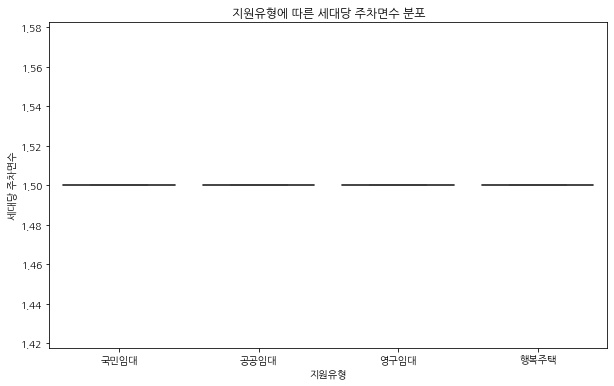

In [23]:
df_inf['세대당_주차면수'] = df_inf['주차면수'] / df_inf['세대수']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_inf, x='지원유형', y='세대당_주차면수')
plt.title('지원유형에 따른 세대당 주차면수 분포')
plt.ylabel('세대당 주차면수')
plt.show()


### 지원유형이 어떻든 세대수의 1.5배 정도의 주차면수를 확보하는 것으로 보인다. 

## 2. 임대료 데이터

- 1차적으로 지원유형에 따른 단지평수의 분포, 단지평수에 다른 월세의 증가 확인 
- 단지평수가 같더라도 지원유형에 따라 월세가 달라질 수 있다? 
- cluster(지역)에 따라 달라지는 건가? 

In [24]:
df_money.columns=['단지코드','단지명','지원유형','단지평수','월세','경도','위도']

In [25]:
df_all=df_money.merge(df_inf, on=['단지명','지원유형','위도','경도','단지코드'])
df_all.drop(['단지코드','경도','위도','세대당_주차면수'],axis=1,inplace=True)
df_all.head()
df_all['지원유형'] = df_all['지원유형'].astype('category')
df_all['단지평수'] = df_all['단지평수'].astype('category')
df_all.info()
# 카테고리 변수 변환


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 122
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   단지명      123 non-null    object  
 1   지원유형     123 non-null    category
 2   단지평수     123 non-null    category
 3   월세       123 non-null    int64   
 4   세대수      123 non-null    int64   
 5   주차면수     123 non-null    float64 
 6   cluster  123 non-null    int32   
dtypes: category(2), float64(1), int32(1), int64(2), object(1)
memory usage: 5.8+ KB


### 지원유형에 따른 단지평수의 분포 
1. 10평 이하에는 국민임대와 행복주택이 분포되어 있다. -> 1인 가구가 살 확률이 가장 높다. 
2. 20평 이하에는 -> 국민임대>행복주택>공공임대 순으로 분포되어 있다. -> 2인 가구 
3. 30평 이하에는 공공임대만 존재함 
- 영구임대는 10평 이하만 존재하면 이는 즉 사회취약계층을 위한 아파트인 것으로 보임 => 30 퍼센트 정도의 매우 저렴한 값에 제공함
- 공공임대는 2,30 평 이하만 존재하는 것으로 보아 부부 및 가족단위를 위한 것으로 임대 후 분양 전환 가능하므로, 주택을 소유할 수 있도록 돕는다.
- 국민임대와 행복주택은 10,20평 이하만 존재하므로 청년, 신혼, 고령자 등 다양한 사람들을 대상으로 제공함 

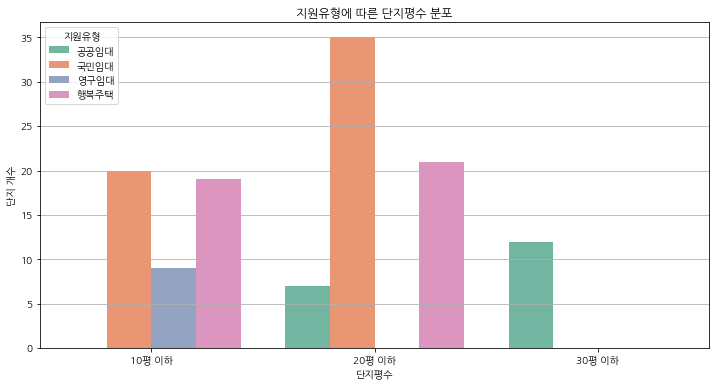

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 지원유형에 따른 단지평수 분포
plt.figure(figsize=(12, 6))
sns.countplot(x='단지평수', hue='지원유형', data=df_all, palette='Set2')
plt.title('지원유형에 따른 단지평수 분포')
plt.xlabel('단지평수')
plt.ylabel('단지 개수')
plt.legend(title='지원유형')
plt.grid(axis='y')
plt.show()


### 지원유형에 따른 단지평수와 월세의 관계
- 공공임대는 개인소유로 전화할 수 있다는 메리트가 있기 때문에 가장 월세가 비싼 것으로 확인 된다. -> 소득이 어느정도 있는 사람들- 공유차량 없이 기존 차량이 있을 가능성이 높다. 
- 국민임대와 행복주택의 월세 분포는 비슷하다. -> 고령자들을 제외한 신혼부부 및 청년들에게 공유차량 지원이 필요할 수 있다. 
- 국민임대개 가장 저렴한 것으로 보이며 -> 어떤 사람들로 분포되어있는지 확인해 봐야 할듯함 

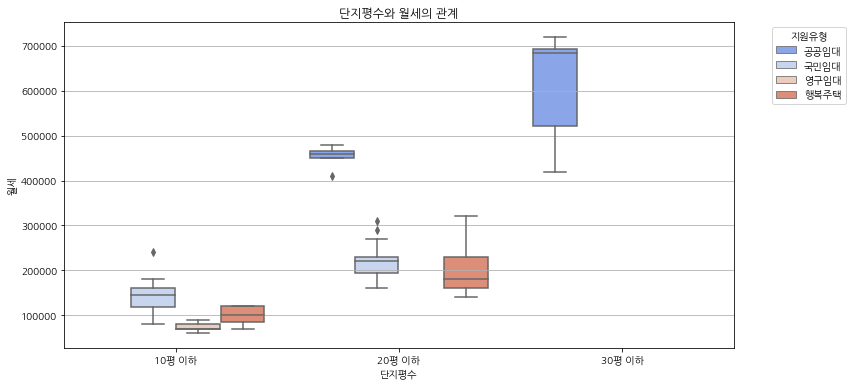

In [22]:
# 단지평수와 월세의 관계
plt.figure(figsize=(12, 6))
sns.boxplot(x='단지평수', y='월세', hue='지원유형', data=df_all, palette='coolwarm')
plt.title('단지평수와 월세의 관계')
plt.xlabel('단지평수')
plt.ylabel('월세')
plt.legend(title='지원유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


### 지역구 별 월세 차이
1. 클러스터 0 지역은 동탄 신도시쪽이다. 
- 국민임대12/ 행복주택11/공공임대10/영구임대4

2. 클러스터 1 지역은 화성 남양뉴타운, 비봉면 쪽에 위치해있음  
- 남양뉴타운: 국민임대4개, 공공임대 1개, 영구임대 1개, 행복주택 3개 
- 화성 비봉: 국민임대 2개, 영구임대 3개, 행복주택 2개 
- 화성 매송: 국민임대 1개 

3. 클러스터 2 지역은 향남 10, 발안 1개
- 국민임대7/행복주택3/공공임대1

4. 클러스터 3 지역은 태안 2지역, 봉담 12개
- 태안: 국민임대 2개
- 봉담: 행복주택 2개, 영구임대 1개, 국민임대 6개, 공공임대 1개


#### 결론: (화성,비봉,향남)과 동탄신도시, 봉담 및 태안의 공유차량 대수에 차별화를 할 필요가 있어 보임 

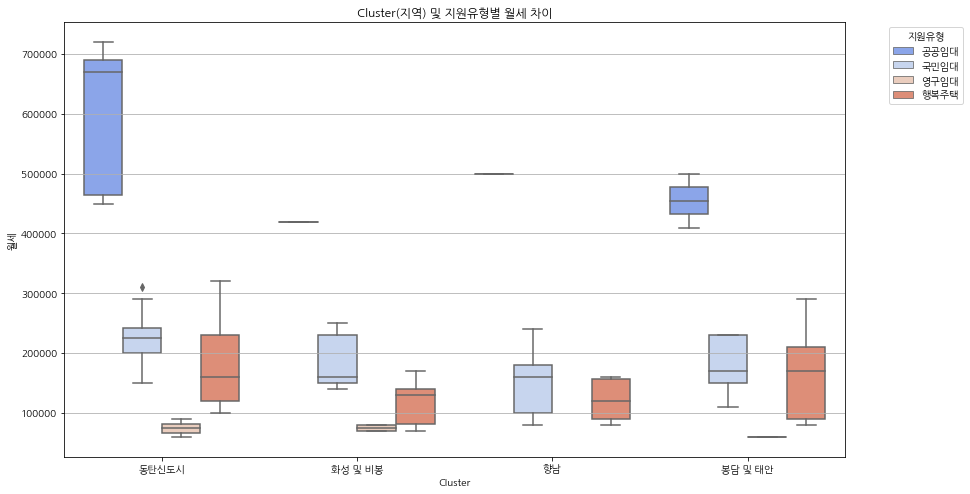

In [24]:

plt.figure(figsize=(14, 8))
sns.boxplot(x='cluster', y='월세', hue='지원유형', data=df_all, palette='coolwarm')
plt.title('Cluster(지역) 및 지원유형별 월세 차이')
plt.xlabel('Cluster')
plt.ylabel('월세')
cluster_labels = ['동탄신도시', '화성 및 비봉', '향남', '봉담 및 태안']
plt.xticks(ticks=[0, 1, 2, 3], labels=cluster_labels)

plt.legend(title='지원유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


## 3. 격자에 거주인구 분포 그리기 연령대별
1. 지도에 격자별로 어떤 연령대가 거주하고 있는지 먼저 파악 
2. 해당 격자가 어떤 지역에 해당하는지 파악
3. 지원유형별로 어떤 사람들이 거주하고 있는지 파악 
4. 연령대가 높아질수록 공유차량의 필요성이 줄어들기 때문에 평균연령을 확실하게 파악해줘야한다. 

In [26]:
df_map.head()

,gid,geometry
0,다사385011,"POLYGON ((126.80784 37.10654, 126.80783 37.107..."
1,다사312110,"POLYGON ((126.72478 37.19526, 126.72477 37.196..."
2,다사473033,"POLYGON ((126.90672 37.12690, 126.90671 37.127..."
3,다사602117,"POLYGON ((127.05149 37.20326, 127.05149 37.204..."
4,다사476205,"POLYGON ((126.90889 37.28195, 126.90888 37.282..."


In [28]:
df1_p= pd.read_csv('../data/1-1.화성시_거주인구.csv')
df_map = gpd.read_file('../data/1-14.화성시_격자.geojson')
df_map_f = df_map.merge(df1_p, on='gid')


<class 'geopandas.geodataframe.GeoDataFrame'>


In [29]:
df_map_f.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 285536 entries, 0 to 285535
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   gid         285536 non-null  object  
 1   geometry    285536 non-null  geometry
 2   year        285536 non-null  int64   
 3   m_20g_pop   24762 non-null   float64 
 4   w_20g_pop   19974 non-null   float64 
 5   m_30g_pop   26447 non-null   float64 
 6   w_30g_pop   20210 non-null   float64 
 7   m_40g_pop   29344 non-null   float64 
 8   w_40g_pop   21545 non-null   float64 
 9   m_50g_pop   38329 non-null   float64 
 10  w_50g_pop   30156 non-null   float64 
 11  m_60g_pop   42323 non-null   float64 
 12  w_60g_pop   35477 non-null   float64 
 13  m_70g_pop   27124 non-null   float64 
 14  w_70g_pop   25971 non-null   float64 
 15  m_80g_pop   15999 non-null   float64 
 16  w_80g_pop   21078 non-null   float64 
 17  m_90g_pop   2630 non-null    float64 
 18  w_90g_pop   7390

In [30]:
age_columns = [
    'm_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop', 'm_40g_pop', 'w_40g_pop',
    'm_50g_pop', 'w_50g_pop', 'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop',
    'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop','m_100g_pop','w_100g_pop'
]


In [31]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. df_inf의 위경도 정보로 geometry 생성
df_inf['geometry'] = df_inf.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
df_inf = gpd.GeoDataFrame(df_inf, geometry='geometry', crs=df_map_f.crs)

# 2. df_map_f에서 2020년 데이터만 선택
df_map_f_2020 = df_map_f[df_map_f['year'] == 2020]

# 3. df_inf와 df_map_f_2020의 격자 매칭 (spatial join)
matched = gpd.sjoin(df_inf, df_map_f_2020, how='inner', op='intersects')



# 관심 격자에서 연령대별 인구 수 합계 계산
matched['total_population'] = matched[age_columns].sum(axis=1)

# 5. 결과 데이터 정리
result = matched[['단지코드', '단지명', '경도', '위도', 'total_population'] + age_columns]


In [32]:
result

,단지코드,단지명,경도,위도,total_population,m_20g_pop,w_20g_pop,m_30g_pop,w_30g_pop,m_40g_pop,...,m_60g_pop,w_60g_pop,m_70g_pop,w_70g_pop,m_80g_pop,w_80g_pop,m_90g_pop,w_90g_pop,m_100g_pop,w_100g_pop
0,C00414,화성태안12,127.041121,37.217786,530.0,39.0,32.0,31.0,31.0,62.0,...,31.0,49.0,27.0,39.0,0.0,18.0,0.0,0.0,NaN,NaN
1,C00415,화성태안6,127.049830,37.212454,357.0,7.0,15.0,38.0,21.0,30.0,...,17.0,45.0,11.0,30.0,12.0,26.0,0.0,0.0,NaN,NaN
2,C00416,화성태안8,127.047309,37.215054,565.0,39.0,54.0,45.0,39.0,57.0,...,34.0,44.0,21.0,28.0,6.0,10.0,0.0,0.0,NaN,NaN
3,C00447,화성매송(1단지)(국임),126.880070,37.266522,361.0,13.0,10.0,22.0,20.0,57.0,...,47.0,48.0,22.0,13.0,0.0,16.0,0.0,0.0,NaN,NaN
4,C01566,화성동탄7-1(1-1)(7단지 능동),127.060256,37.216649,113.0,7.0,9.0,12.0,11.0,12.0,...,6.0,13.0,0.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,C02732,화성향남2 B-15블록 행복주택,126.906868,37.102767,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,C02758,화성동탄2 A-53블록 행복주택,127.142678,37.187770,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,C02784,화성비봉 A-5블록 행복·영구임대주택,126.866536,37.248863,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,C02784,화성비봉 A-5블록 행복·영구임대주택,126.866536,37.248863,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
result.query('total_population==0').단지명.to_list()

['화성동탄7-3(1-2,3)(7단지 능동)',
 '화성남양뉴타운(LH9단지)(국임)',
 '화성향남2(18단지 언덕)(국임)',
 '화성동탄2 A77-2블럭(35단지)(국임/영구)',
 '화성동탄2 A77-2블럭(35단지)(국임/영구)',
 '화성동탄2 A4-2블럭(2단지)(국임/영구)',
 '화성동탄2 A4-2블럭(2단지)(국임/영구)',
 '병점복합타운A1행복주택',
 '화성태안3 A1블록 국민임대주택',
 '화성태안3 A2블록 국민임대주택',
 '화성동탄2 A104블록 신혼희망타운 행복주택',
 '화성비봉 A-2블록 행복주택',
 '화성상리 1블록 행복주택',
 '화성비봉 A-1블록 국민영구임대주택',
 '화성비봉 A-1블록 국민영구임대주택',
 '화성동탄2 지원6-2블록 지역전략산업지원주택',
 '화성동탄2 A57-1블록 행복주택',
 '남양뉴타운 B-9블록 행복주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '화성봉담2 A-2블록 신혼희망타운 행복주택',
 '화성능동 B-1블록 신혼희망타운 행복주택',
 '화성비봉 A-4블록 국민·영구임대주택',
 '화성비봉 A-4블록 국민·영구임대주택',
 '화성향남2 B-15블록 행복주택',
 '화성동탄2 A-53블록 행복주택',
 '화성비봉 A-5블록 행복·영구임대주택',
 '화성비봉 A-5블록 행복·영구임대주택',
 '화성동탄2 A-54블록 행복주택']

## 매우중요- NAN이 0이 아닌 거 같다. -> 0 대신 다른 값으로 결측치 처리가 필요할듯 
1. 주변 거주지역의 연령비율을 반영
2. 해당 아파트의 세대수가 정해져 있기 때문에 세대수에 맞게 비율을 처리해야 함 

#### 좋은 방법
1. 주변 아파트(동일 클러스터) + 같은 지원유형 + 같은 평수 
2. 만약 주변에 같은 지워유형과 평수가 없다면 주변 비슷한 클러스터를 참고해야 할듯 한다. 

In [34]:
missing_apartments = result.query('total_population == 0').단지명.to_list()

nan_rows = result[result['단지명'].isin(missing_apartments)] # 결측치를 채워야 하는 행 
data_rows = result[~result['단지명'].isin(missing_apartments)]
nan_rows

,단지코드,단지명,경도,위도,total_population,m_20g_pop,w_20g_pop,m_30g_pop,w_30g_pop,m_40g_pop,...,m_60g_pop,w_60g_pop,m_70g_pop,w_70g_pop,m_80g_pop,w_80g_pop,m_90g_pop,w_90g_pop,m_100g_pop,w_100g_pop
5,C01567,"화성동탄7-3(1-2,3)(7단지 능동)",127.060192,37.213290,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,C02042,화성남양뉴타운(LH9단지)(국임),126.833895,37.209028,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,C02049,화성향남2(18단지 언덕)(국임),126.896338,37.097377,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,C02413,화성동탄2 A77-2블럭(35단지)(국임/영구),127.121299,37.164322,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,C02413,화성동탄2 A77-2블럭(35단지)(국임/영구),127.121299,37.164322,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,C02512,화성동탄2 A4-2블럭(2단지)(국임/영구),127.105712,37.211973,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,C02512,화성동탄2 A4-2블럭(2단지)(국임/영구),127.105712,37.211973,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,C02521,병점복합타운A1행복주택,127.031258,37.202760,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,C02523,화성태안3 A1블록 국민임대주택,127.000294,37.205203,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,C02524,화성태안3 A2블록 국민임대주택,127.002503,37.204388,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 결측치 있는 곳이 이상해서 주변 500m 반경까지 인구가 없는지 확인해봄

In [35]:
# 단지 중심 좌표로부터 Buffer 생성 (반경 500m)
df_inf['geometry'] = df_inf['geometry'].buffer(0.005)

# 2020년 데이터 필터링
df_map_f_2020 = df_map_f[df_map_f['year'] == 2020]

# Buffer와 격자 데이터의 Spatial Join
matched = gpd.sjoin(df_inf, df_map_f_2020, how='inner', op='intersects')

# 겹친 데이터의 연령대별 인구 합계 계산
matched['total_population'] = matched[age_columns].sum(axis=1)

# 결과 데이터 정리
result2 = matched[['단지코드', '단지명', '경도', '위도', 'total_population'] + age_columns]


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [41]:
result2.query('total_population==0').head()

,단지코드,단지명,경도,위도,total_population,m_20g_pop,w_20g_pop,m_30g_pop,w_30g_pop,m_40g_pop,...,m_60g_pop,w_60g_pop,m_70g_pop,w_70g_pop,m_80g_pop,w_80g_pop,m_90g_pop,w_90g_pop,m_100g_pop,w_100g_pop
0,C00414,화성태안12,127.041121,37.217786,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2,C00416,화성태안8,127.047309,37.215054,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
0,C00414,화성태안12,127.041121,37.217786,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C00416,화성태안8,127.047309,37.215054,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,C00414,화성태안12,127.041121,37.217786,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
missing_apartments

['화성동탄7-3(1-2,3)(7단지 능동)',
 '화성남양뉴타운(LH9단지)(국임)',
 '화성향남2(18단지 언덕)(국임)',
 '화성동탄2 A77-2블럭(35단지)(국임/영구)',
 '화성동탄2 A77-2블럭(35단지)(국임/영구)',
 '화성동탄2 A4-2블럭(2단지)(국임/영구)',
 '화성동탄2 A4-2블럭(2단지)(국임/영구)',
 '병점복합타운A1행복주택',
 '화성태안3 A1블록 국민임대주택',
 '화성태안3 A2블록 국민임대주택',
 '화성동탄2 A104블록 신혼희망타운 행복주택',
 '화성비봉 A-2블록 행복주택',
 '화성상리 1블록 행복주택',
 '화성비봉 A-1블록 국민영구임대주택',
 '화성비봉 A-1블록 국민영구임대주택',
 '화성동탄2 지원6-2블록 지역전략산업지원주택',
 '화성동탄2 A57-1블록 행복주택',
 '남양뉴타운 B-9블록 행복주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '남양뉴타운 B-10블록 행복·국민·영구임대주택',
 '화성봉담2 A-2블록 신혼희망타운 행복주택',
 '화성능동 B-1블록 신혼희망타운 행복주택',
 '화성비봉 A-4블록 국민·영구임대주택',
 '화성비봉 A-4블록 국민·영구임대주택',
 '화성향남2 B-15블록 행복주택',
 '화성동탄2 A-53블록 행복주택',
 '화성비봉 A-5블록 행복·영구임대주택',
 '화성비봉 A-5블록 행복·영구임대주택',
 '화성동탄2 A-54블록 행복주택']

##  결론 
1. 아파트 전체 단지가 500명 밖에 살 일이 없기 때문에 주변 반경을 찾아보는 것이 필요할 것 같긴 함 
2. 주변 얼마나 찾아봐야할지 90개 정도 단지 밖에 없기 때문에 일일히 전체 땅 면적을 찾아봐야 할거 같음 - LH 기준이 있을 수도? ( 단지의 개수, 기준 동 수 ). 
3. 주변반경으로 해서 인구수 찾아보려고 했지만 그럼에도 결측치가 존재함. 이 때는 어떻게 해야할지? -> 다른 아파트단지와의 유사도로 비교해봐야할까? - 평수, 유사지역여부, 지원유형 등 
### 결론적으로, QGIS를 활용하여 직접 격자를 보며 각 아파트 단지마다 포함하는 격자를 보고 거주인구를 결정해야 할 것 같다.